In [11]:
import matplotlib.pyplot as plt
import itertools


def plot_neural_input(res, position=15):
    plt.plot(res.e_.auditory_total_input[:, position], label="Auditory")
    plt.plot(res.e_.visual_total_input[:, position], label="Visual")
    plt.plot(res.e_.multi_total_input[:, position], label="Multisensory")
    plt.ylabel("Neural input", size=14)
    plt.xlabel("Time", size=14)
    plt.legend()
    plt.show()


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(position=15, ax=axs[row, col])
        sub_plot.get_legend().remove()
        sub_plot.set_title("SOA " + str(int(res.run_params.soa)) + " ms")

    handles, labels = sub_plot.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", borderaxespad=0.1)
    plt.subplots_adjust(right=0.935)
    plt.show()


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size

In [12]:
from scipy.optimize import curve_fit


def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


## Sigmoid function fitting
def sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    a = np.max(y)
    b = np.min(y)

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    # if initial_slope>=0: initial_slope=-0.0001
    middle_x = np.max(x) / 2
    init_guess = [a, b, middle_x, initial_slope]
    boundaries = ([0, 0, 36, float("-inf")], [100, 100, 204, 0])

    # Fits the data
    popt, _ = curve_fit(
        sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    a = sigpar[0]
    b = sigpar[1]
    c = sigpar[2]
    d = sigpar[3]

    return a, b, c, d

## Experimental Data

In [5]:
import pandas as pd
import numpy as np


def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

## TODO double check fit values

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

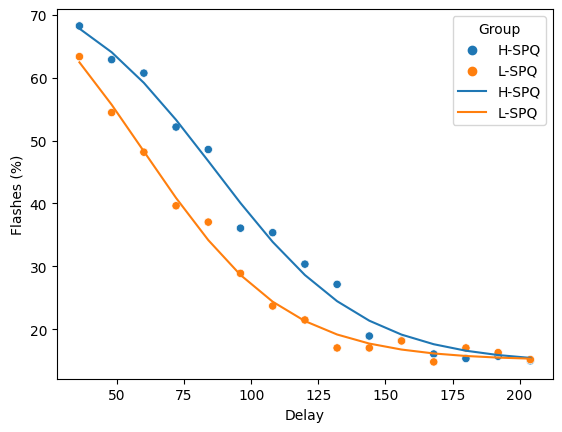

In [7]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

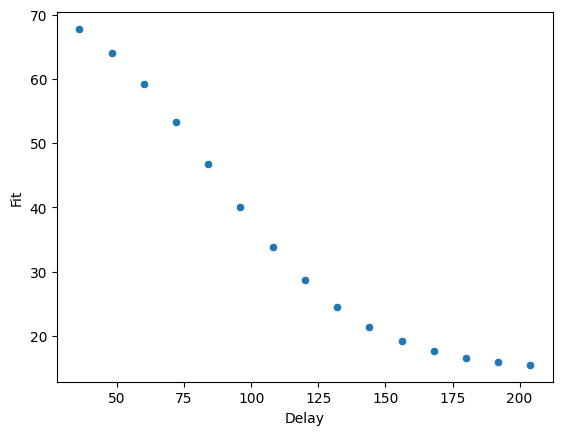

In [8]:
# Data to fit
hspq_data = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay")

## Fitting

In [25]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from scipy.optimize import differential_evolution
from findpeaks import findpeaks


def myjob(soa, l_ex):
    model = Paredes2022(
        time_range=(0, 550),
        neurons=30,
        position_range=(0, 30),
        tau=(6.712e00, 2.356e01, 1.175e02),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        lateral_excitation=l_ex,
        cross_modal_weight=1.327e-02,
        feedback_weight=2.423e-01,
        feedforward_weight=2.461e00,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    fp_results = fp.fit(res.get_modes("visual").query("positions==15").visual.values)
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes


def hspq_cost(theta):
    two_flashes = []
    for soa in soas:
        two_flashes_per_soa = myjob(soa=soa, l_ex=theta[0])
        two_flashes.append(two_flashes_per_soa)

    model_data = np.array(two_flashes) * 100
    exp_data = hspq_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(1.5, 1.7)]
hspq_fit_res = differential_evolution(
    hspq_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)

differential_evolution step 1: f(x)= 0.0667248
differential_evolution step 2: f(x)= 0.0550032
differential_evolution step 3: f(x)= 0.0550032
differential_evolution step 4: f(x)= 0.0550032
differential_evolution step 5: f(x)= 0.0550032
differential_evolution step 6: f(x)= 0.0549122
differential_evolution step 7: f(x)= 0.0549035
differential_evolution step 8: f(x)= 0.0548751


In [27]:
print(hspq_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 0.05487507446394833
       x: [ 1.632e+00]
     nit: 8
    nfev: 135


## Exploration

In [18]:
from skneuromsi.neural import Paredes2022
import numpy as np
from findpeaks import findpeaks


def myjob_explore(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau):
    model = Paredes2022(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=1.632e00,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    fp_results = fp.fit(res.get_modes("visual").query("positions==15").visual.values)
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes, res

In [19]:
from joblib import Parallel, delayed

with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_explore)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

fb_raw_model_data = np.array(two_flashes) * 100

In [15]:
sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, fb_raw_model_data)
print(a, b, c, d)
fb_model_data = sig(sig_soas, a, b, c, d)

15.14708612588788 45.35766433810407 102.53690944896198 -20.708505194341083


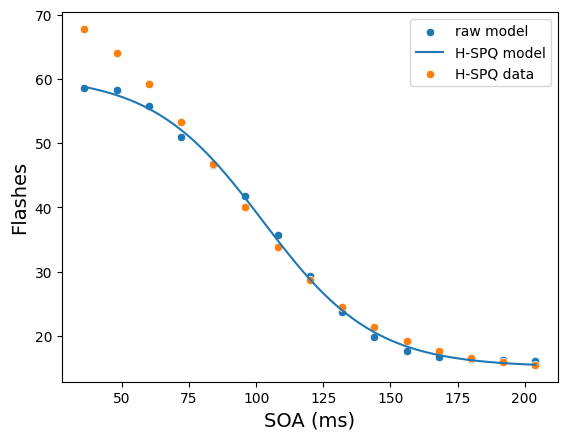

In [20]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=fb_raw_model_data, label="raw model")
sns.lineplot(x=sig_soas, y=fb_model_data, label="H-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay", label="H-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

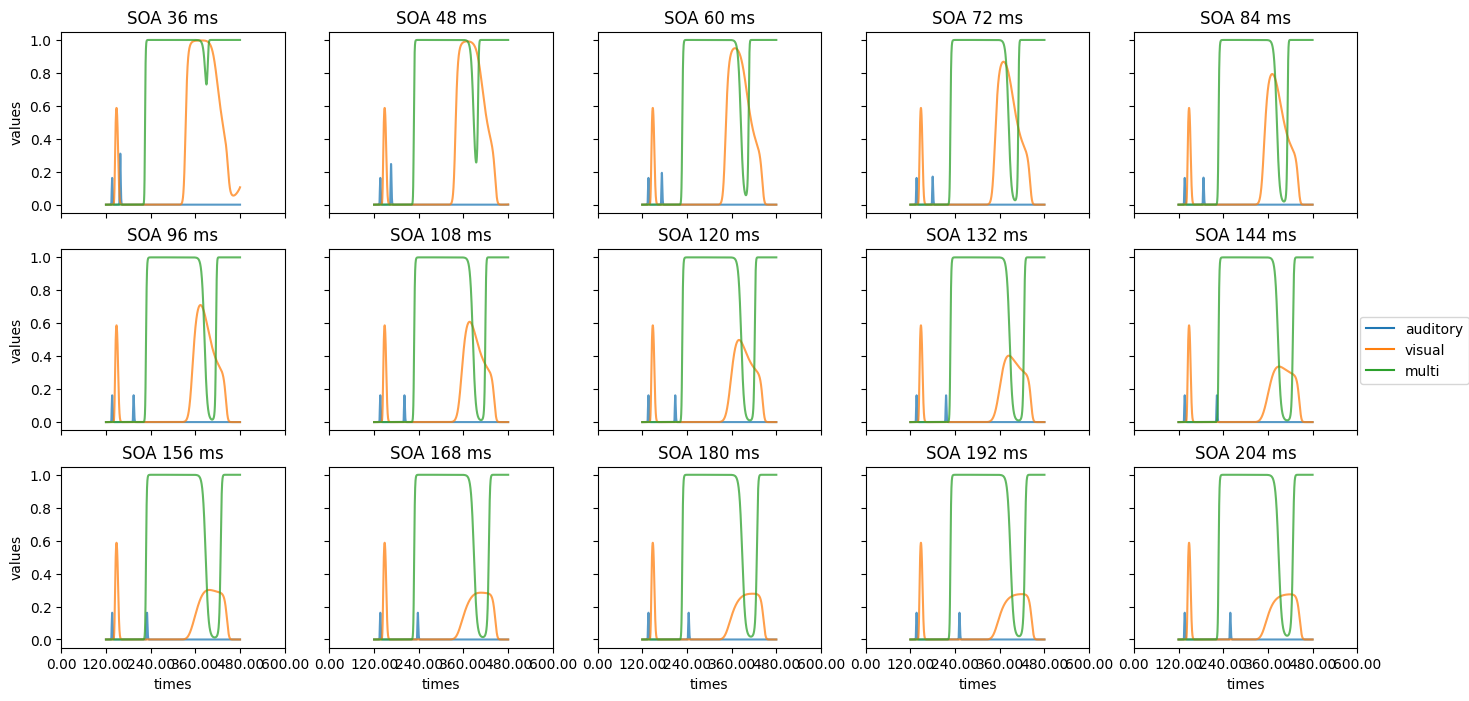

In [21]:
plot_res_per_soa(results)

In [33]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(fb_raw_model_data, dataset.query("Group == 'H-SPQ'").Fit.values, 1)
print(scz_error)

32.09356254995928
